In [1]:
! pip install transformers
! pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
from google.colab import drive
drive.mount('/content/drive')
GOOGLE_DIR="/content/drive/MyDrive/Data"
LOCAL_DIR="/scratch/t.tovi/datasets"

# # # Download the datasets
# # !wget --directory-prefix=$DIR http://images.cocodataset.org/zips/train2017.zip
# # !wget --directory-prefix=$DIR http://images.cocodataset.org/zips/val2017.zip
# # !wget --directory-prefix=$DIR http://calvin.inf.ed.ac.uk/wp-content/uploads/data/cocostuffdataset/stuffthingmaps_trainval2017.zip

#Unpack the datasets
!mkdir -p {LOCAL_DIR}/COCO_stuff_images
!mkdir -p {LOCAL_DIR}/COCO_stuff_annotations

#!cp {GOOGLE_DIR}/train2017.zip {LOCAL_DIR}/COCO_stuff_images/
!cp {GOOGLE_DIR}/val2017.zip {LOCAL_DIR}/COCO_stuff_images/
!cp {GOOGLE_DIR}/stuffthingmaps_trainval2017.zip {LOCAL_DIR}/COCO_stuff_annotations/

#!unzip {LOCAL_DIR}/COCO_stuff_images/train2017.zip -d {LOCAL_DIR}/COCO_stuff_images/
!unzip {LOCAL_DIR}/COCO_stuff_images/val2017.zip -d {LOCAL_DIR}/COCO_stuff_images/
!unzip {LOCAL_DIR}/COCO_stuff_annotations/stuffthingmaps_trainval2017.zip -d {LOCAL_DIR}/COCO_stuff_annotations/

Streaming output truncated to the last 5000 lines.
  inflating: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/000000222235.png  
  inflating: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/000000038678.png  
  inflating: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/000000189698.png  
  inflating: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/000000208363.png  
 extracting: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/000000572956.png  
  inflating: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/000000384513.png  
 extracting: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/000000471893.png  
 extracting: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/000000302536.png  
  inflating: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/000000531036.png  
  inflating: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/000000087038.png  
  inflating: /scratch/t.tovi/datasets/COCO_stuff_annotations/val2017/

In [3]:
import torch
from torch import nn
from transformers import CLIPProcessor, CLIPModel, CLIPTextModelWithProjection, CLIPVisionModelWithProjection
import torch.nn.functional as F
from torch.utils.data import Dataset
from PIL import Image
from torchvision import transforms
import torchvision.transforms.functional as TF
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR, StepLR
import tqdm
from transformers import AutoProcessor, CLIPSegForImageSegmentation

In [4]:
src_dir = "./"
dataset_dir = "/scratch/t.tovi/datasets/"
image_dir = "COCO_stuff_images/val2017/"
annotation_dir = "COCO_stuff_annotations/val2017/"

class COCOStuffDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, img_size=224):
        """
        Args:
            image_dir (string): Directory with all the images.
            annotation_dir (string): Directory with all the annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.images = os.listdir(image_dir)
        self.img_size = img_size

        self.selected_labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48,
                                49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90]

        # Load the label mapping
        self.digit_to_object_mapping = {}
        with open(f'{src_dir}labels.txt', 'r') as file:
            for line in file:
                key, value = line.strip().split(':')
                self.digit_to_object_mapping[int(key)] = value.strip()
        self.digit_to_object_mapping[255] = "unlabled"

    def center_crop(self, image, mask):
        transform = transforms.CenterCrop(self.img_size)
        return transform(image), transform(mask)

    def resize(self, image, mask):
        transform = transforms.CenterCrop(min(image.size))

        cropped_image = transform(image)
        cropped_mask = transform(mask)

        resized_image = transforms.Resize((self.img_size, self.img_size),transforms.InterpolationMode.BILINEAR)(cropped_image)
        resized_mask= transforms.Resize((self.img_size, self.img_size), transforms.InterpolationMode.NEAREST)(cropped_mask)
        return resized_image, resized_mask

    def __len__(self):
        return len(self.images)

    def get(self, idx):
        # Load image
        img_name = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_name)#.convert('RGB')

        annotation_name = os.path.join(self.annotation_dir, self.images[idx].replace('.jpg', '.png'))
        annotation = Image.open(annotation_name)

        ids = np.unique(np.array(annotation))
        ids = [id for id in ids if id in self.selected_labels]
        labels = [self.digit_to_object_mapping[id] for id in ids]

        return image, annotation, labels

    def __getitem__(self, idx):
        # Load image
        img_name = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_name).convert('RGB')

        # Load annotation
        annotation_name = os.path.join(self.annotation_dir, self.images[idx].replace('.jpg', '.png'))
        annotation = Image.open(annotation_name)

        image, mask = self.resize(image, annotation)
        mask = np.array(mask)
        mask += 1
        mask[mask==256] = 0


        # Indexed masks
        ids = np.unique(mask)
        ids = [id for id in ids if id in self.selected_labels]
        nonempty_masks = [np.full(mask.shape, id) * (mask==id) for id in ids]
        nonempty_masks = sorted(nonempty_masks, key=lambda x: np.sum(x!=0), reverse=True)

        # Get ids and labels
        ids = [np.unique(mask)[-1] for mask in nonempty_masks]
        labels = [self.digit_to_object_mapping[id] for id in ids]

        # Convert to binary masks
        nonempty_masks = [(mask != 0).astype(float) for mask in nonempty_masks]

        sample = {'image': image, 'annotation': nonempty_masks, 'labels': labels, 'ids': ids}

        return sample

In [5]:
def collate_fn_factory(processor, max_size=20):

    def collate_fn(batch):
        size = processor.image_processor.size['height'] #224
        transform = transforms.ToTensor()

        # Preprocess pixel values
        images = [each['image'].convert('RGB') for each in batch]
        batch_pixel_values = processor(None, images=images, return_tensors='pt')['pixel_values']

        for pixel_values in batch_pixel_values:
            if pixel_values.shape[0] < 3:
                pixel_values = pixel_values.repeat(3, 1, 1)

        for pixel_values in batch_pixel_values:
            assert pixel_values.shape[0] == 3

        # Preprocess labels
        ids = torch.full((len(batch), max_size), 0)
        ids[:, :max_size] = torch.tensor([each['ids'][:max_size] + [0] * (max_size - len(each['ids'])) for each in batch])

        # Preprocess masks
        batch_masks = np.stack([
            np.stack(each['annotation'][:max_size] + [np.zeros((size, size))] * (max_size - len(each['annotation'])) )
            for each in batch
        ])
        batch_masks = torch.tensor(batch_masks[:, :max_size])

        return {
            "pixel_values": batch_pixel_values,
            "masks": batch_masks.type(torch.float32),
            "ids": ids.type(torch.long)
        }

    return collate_fn

In [6]:
class CoSeg_no_train(nn.Module):
    def __init__(self, all_labels):
        super(CoSeg_no_train, self).__init__()
        self.all_labels = all_labels

        self.processor = AutoProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
        self.segmentation_model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

        label_text = [f"a photo of {label}" for label in all_labels]
        self.label_indices = self.processor(label_text, padding=True, return_tensors='pt')['input_ids']
        with torch.no_grad():
            label_embeddings = self.segmentation_model.clip.text_model(input_ids=self.label_indices)["pooler_output"]
            self.label_embeddings = self.segmentation_model.clip.text_projection(label_embeddings)

    def forward(self, pixel_values):
        if self.label_embeddings.device != pixel_values.device:
            self.label_embeddings = self.label_embeddings.to(pixel_values.device)
            self.label_indices = self.label_indices.to(pixel_values.device)

        # Select the top20 probable classes
        image_embedding = self.segmentation_model.clip.vision_model(pixel_values, None)["pooler_output"]
        image_embedding = self.segmentation_model.clip.visual_projection(image_embedding)
        similarities = F.cosine_similarity(image_embedding, self.label_embeddings, dim=1)
        indices = torch.topk(similarities, 20, largest=True, sorted=True).indices
        input_ids = self.label_indices[indices]

        # Generate mask logits
        logits = self.segmentation_model(pixel_values=pixel_values.repeat(20, 1, 1, 1), input_ids=input_ids).logits
        return logits, self.label_embeddings[indices]


In [7]:
import math

def mean_iou(y_true, y_pred, classes):
    """
    Compute the Intersection over Union (IoU) for each class in the list.

    Parameters:
    y_true (np.array): The ground truth labels.
    y_pred (np.array): The predicted labels.
    classes (list): A list of class IDs to compute IoU for.

    Returns:
    np.array: An array of IoUs for each class in the list.
    """
    iou_list = []
    for class_id in classes:
        true_positive = torch.sum((y_true == class_id) & (y_pred == class_id))
        false_positive = torch.sum((y_true != class_id) & (y_pred == class_id))
        false_negative = torch.sum((y_true == class_id) & (y_pred != class_id))
        union = true_positive + false_positive + false_negative

        if union == 0:
            iou = 1.0  # Perfect match or no data for the class
        else:
            iou = true_positive / union

        if torch.isnan(iou):
            iou = 0.0

        iou_list.append(iou.detach().cpu().item())
    return np.mean(iou_list)

In [8]:
device = 0

# Define dataset dir
dataset_dir = "/scratch/t.tovi/datasets/"

# Create dataset object
data = COCOStuffDataset(
    dataset_dir+"COCO_stuff_images/val2017",
    dataset_dir+"COCO_stuff_annotations/val2017",
    img_size=352
)

FileNotFoundError: [Errno 2] No such file or directory: './labels.txt'

In [ ]:
labels = data.digit_to_object_mapping.values()
model = CoSeg_no_train(labels).to(0)

# Get the collate function
collate_fn = collate_fn_factory(model.processor)

# Create batch data loader
data_loader = DataLoader(data, batch_size=1, collate_fn=collate_fn, num_workers=2, shuffle=True)

m = nn.Sigmoid()

In [ ]:
all_miou = []
for batch in tqdm.tqdm(data_loader):
    pixel_values = batch['pixel_values'].to(device)
    masks = batch['masks'].to(device)
    ids = batch['ids'].to(device)

    mask_logits, pred_embeddings = model(pixel_values)

    ids = batch['ids'].squeeze(0)
    ids = ids[ids != 0]
    ground_truth_embeddings = model.label_embeddings[ids]
    predicted_embeddings = F.normalize(pred_embeddings, dim=-1).squeeze(0)
    correspondence = torch.argmax(ground_truth_embeddings @ predicted_embeddings.T, dim=-1)

    predicted_masks = (m(mask_logits[correspondence])> 0.1).int()
    for i in range(len(ids)):
        predicted_masks[i] = predicted_masks[i] * ids[i]

    ground_truth_masks = masks.squeeze(0)[: len(ids)]
    for i in range(len(ids)):
        ground_truth_masks[i] = ground_truth_masks[i] * ids[i]

    score = mean_iou(ground_truth_masks, predicted_masks, ids)
    all_miou.append(score)

    if len(all_miou) % 100 == 0:
        print(np.nanmean(all_miou))

# Pascal VOC 2012

In [ ]:
#Unpack the datasets

!cp {GOOGLE_DIR}/VOCtrainval_11-May-2012.tar {LOCAL_DIR}

!tar -xvf {GOOGLE_DIR}/VOCtrainval_11-May-2012.tar -C {LOCAL_DIR}

Streaming output truncated to the last 5000 lines.
VOCdevkit/VOC2012/SegmentationClass/2008_001874.png
VOCdevkit/VOC2012/SegmentationClass/2008_001876.png
VOCdevkit/VOC2012/SegmentationClass/2008_001882.png
VOCdevkit/VOC2012/SegmentationClass/2008_001885.png
VOCdevkit/VOC2012/SegmentationClass/2008_001895.png
VOCdevkit/VOC2012/SegmentationClass/2008_001896.png
VOCdevkit/VOC2012/SegmentationClass/2008_001926.png
VOCdevkit/VOC2012/SegmentationClass/2008_001966.png
VOCdevkit/VOC2012/SegmentationClass/2008_001971.png
VOCdevkit/VOC2012/SegmentationClass/2008_001992.png
VOCdevkit/VOC2012/SegmentationClass/2008_001997.png
VOCdevkit/VOC2012/SegmentationClass/2008_002032.png
VOCdevkit/VOC2012/SegmentationClass/2008_002043.png
VOCdevkit/VOC2012/SegmentationClass/2008_002064.png
VOCdevkit/VOC2012/SegmentationClass/2008_002066.png
VOCdevkit/VOC2012/SegmentationClass/2008_002067.png
VOCdevkit/VOC2012/SegmentationClass/2008_002073.png
VOCdevkit/VOC2012/SegmentationClass/2008_002079.png
VOCdevkit/VOC

In [ ]:
class PascalDatasetEval(Dataset):
    def __init__(self, val_ids_file, image_dir, annotation_dir, img_size=224):
        """
        Args:
            image_dir (string): Directory with all the images.
            annotation_dir (string): Directory with all the annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.images = []
        with open(val_ids_file, 'r') as file:
            for line in file:
                id = line.strip() + ".jpg"
                self.images.append(id)

        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.img_size = img_size

        # Load the label mapping
        self.digit_to_object_mapping = {}
        with open(f'{src_dir}test_labels.txt', 'r') as file:
            for line in file:
                key, value = line.strip().split(':')
                self.digit_to_object_mapping[int(key)] = value.strip()
        self.digit_to_object_mapping[255] = "unlabled"

    def center_crop(self, image, mask):
        transform = transforms.CenterCrop(self.img_size)
        return transform(image), transform(mask)

    def resize(self, image, mask):
        transform = transforms.CenterCrop(min(image.size))

        cropped_image = transform(image)
        cropped_mask = transform(mask)

        resized_image = transforms.Resize((self.img_size, self.img_size),transforms.InterpolationMode.BILINEAR)(cropped_image)
        resized_mask= transforms.Resize((self.img_size, self.img_size), transforms.InterpolationMode.NEAREST)(cropped_mask)
        return resized_image, resized_mask

    def __len__(self):
        return len(self.images)

    def get(self, idx):
        # Load image
        img_name = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_name)#.convert('RGB')

        annotation_name = os.path.join(self.annotation_dir, self.images[idx].replace('.jpg', '.png'))
        annotation = Image.open(annotation_name)

        ids = np.unique(np.array(annotation))
        labels = [self.digit_to_object_mapping[id] for id in ids]

        return image, annotation, labels

    def __getitem__(self, idx):
        # Load image
        img_name = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_name)#.convert('RGB')

        # Load annotation
        annotation_name = os.path.join(self.annotation_dir, self.images[idx].replace('.jpg', '.png'))
        annotation = Image.open(annotation_name)

        image, mask = self.resize(image, annotation)
        mask = np.array(mask)
        #mask += 1
        mask[mask==255] = 0


        # Indexed masks
        ids = np.unique(mask)
        ids = [id for id in ids if id != 0]
        nonempty_masks = [np.full(mask.shape, id) * (mask==id) for id in ids]
        nonempty_masks = sorted(nonempty_masks, key=lambda x: np.sum(x!=0), reverse=True)

        # Get ids and labels
        ids = [np.unique(mask)[-1] for mask in nonempty_masks]
        labels = [self.digit_to_object_mapping[id] for id in ids]

        # Convert to binary masks
        nonempty_masks = [(mask != 0).astype(float) for mask in nonempty_masks]

        sample = {'image': image, 'annotation': nonempty_masks, 'labels': labels, 'ids': ids}

        return sample

In [ ]:
device = 0

src_dir = "./"
dataset_dir = "/scratch/t.tovi/datasets/"
image_dir = "VOCdevkit/VOC2012/JPEGImages/"
annotation_dir = "VOCdevkit/VOC2012/SegmentationClass/"
val_ids = "VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt"

# Define dataset dir
dataset_dir = "/scratch/t.tovi/datasets/"

# Create dataset object
data = PascalDatasetEval(
    dataset_dir+val_ids,
    dataset_dir+image_dir,
    dataset_dir+annotation_dir,
    img_size=352
)

labels = data.digit_to_object_mapping.values()
model = CoSeg_no_train(labels).to(0)
processor = model.processor

In [ ]:
# Get the collate function
collate_fn = collate_fn_factory(processor)

# Create batch data loader
data_loader = DataLoader(data, batch_size=1, collate_fn=collate_fn, num_workers=2, shuffle=True)

m = nn.Sigmoid()

In [ ]:
all_miou = []
for batch in tqdm.tqdm(data_loader):
    pixel_values = batch['pixel_values'].to(device)
    masks = batch['masks'].to(device)
    ids = batch['ids'].to(device)

    mask_logits, pred_embeddings = model(pixel_values)

    ids = batch['ids'].squeeze(0)
    ids = ids[ids != 0]
    ground_truth_embeddings = model.label_embeddings[ids]
    predicted_embeddings = F.normalize(pred_embeddings, dim=-1).squeeze(0)
    correspondence = torch.argmax(ground_truth_embeddings @ predicted_embeddings.T, dim=-1)

    predicted_masks = (m(mask_logits[correspondence])> 0.2).int()
    for i in range(len(ids)):
        predicted_masks[i] = predicted_masks[i] * ids[i]

    ground_truth_masks = masks.squeeze(0)[: len(ids)]
    for i in range(len(ids)):
        ground_truth_masks[i] = ground_truth_masks[i] * ids[i]

    score = mean_iou(ground_truth_masks, predicted_masks, ids)
    all_miou.append(score)

    if len(all_miou) % 100 == 0:
        print(np.nanmean(all_miou))

        # fig, axs = plt.subplots(1, 3, figsize=(10, 5))
        # axs[0].imshow(m(pixel_values[0]).cpu().detach().numpy().transpose(1, 2, 0))
        # axs[1].imshow(mask_logits[0].cpu().detach().numpy() > 1)
        # axs[2].imshow(ground_truth_masks[0].cpu().detach().numpy())

        # plt.show()

  7%|▋         | 100/1449 [01:06<15:17,  1.47it/s]

0.6068805606504126


 14%|█▍        | 200/1449 [02:18<15:26,  1.35it/s]

0.6202862240247972


 21%|██        | 300/1449 [03:31<13:58,  1.37it/s]

0.6208516403509873


 28%|██▊       | 400/1449 [04:45<12:50,  1.36it/s]

0.6149325936895281


 35%|███▍      | 500/1449 [05:58<11:31,  1.37it/s]

0.6145546780289423


 40%|███▉      | 573/1449 [06:51<10:40,  1.37it/s]/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
 41%|████▏     | 600/1449 [07:11<10:20,  1.37it/s]

0.6178941685775694


 48%|████▊     | 700/1449 [08:24<09:10,  1.36it/s]

0.6172132522735455


 55%|█████▌    | 800/1449 [09:38<07:57,  1.36it/s]

0.6173565380375784


 62%|██████▏   | 900/1449 [10:51<06:42,  1.36it/s]

0.615633110844592


 69%|██████▉   | 1000/1449 [12:05<05:30,  1.36it/s]

0.6146047912948307


 76%|███████▌  | 1100/1449 [13:18<04:14,  1.37it/s]

0.6130753178390188


 83%|████████▎ | 1200/1449 [14:32<03:03,  1.36it/s]

0.6125387594867928


 90%|████████▉ | 1300/1449 [15:45<01:48,  1.37it/s]

0.613450252388979


 97%|█████████▋| 1400/1449 [16:58<00:36,  1.36it/s]

0.6113267490243678


100%|██████████| 1449/1449 [17:34<00:00,  1.37it/s]


In [ ]:
! ls /scratch/t.tovi/datasets/

COCO_stuff_annotations	labels.txt  trainval.tar.gz  VOCtrainval_03-May-2010.tar
COCO_stuff_images	trainval    VOCdevkit	     VOCtrainval_11-May-2012.tar


# Pascal Context

In [9]:
! cp {GOOGLE_DIR}/trainval.tar.gz {LOCAL_DIR}
! cp {GOOGLE_DIR}/VOCtrainval_03-May-2010.tar {LOCAL_DIR}

! tar -xvf {GOOGLE_DIR}/trainval.tar.gz -C {LOCAL_DIR}
! tar -xvf {GOOGLE_DIR}/VOCtrainval_03-May-2010.tar -C {LOCAL_DIR}

Streaming output truncated to the last 5000 lines.
VOCdevkit/VOC2010/JPEGImages/2010_004750.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004751.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004753.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004756.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004757.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004760.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004763.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004765.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004766.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004768.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004770.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004772.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004773.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004775.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004777.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004778.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004779.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004782.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004783.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004785.jpg
VOCdevkit/VOC2010/JPEGImages/2010_004786.jpg
VOCd

In [10]:
from scipy.io import loadmat

class PascalContextEval(Dataset):
    def __init__(self, val_ids_file, image_dir, annotation_dir, img_size=224):
        """
        Args:
            image_dir (string): Directory with all the images.
            annotation_dir (string): Directory with all the annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.images = []
        with open(val_ids_file, 'r') as file:
            for line in file:
                id = line.strip() + ".jpg"
                self.images.append(id)

        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.img_size = img_size

        # Load the label mapping
        self.digit_to_object_mapping = {}
        with open('/scratch/t.tovi/datasets/labels.txt', 'r') as file:
            for line in file:
                key, value = line.strip().split(':')
                self.digit_to_object_mapping[int(key)] = value.strip()

        # self.selected_labels = [
        #     0, 2, 259, 260, 415, 324, 9, 258, 144, 18, 19, 22,
        #     23, 397, 25, 284, 158, 159, 416, 33, 162, 420, 454, 295, 296,
        #     427, 44, 45, 46, 308, 59, 440, 445, 31, 232, 65, 354, 424,
        #     68, 326, 72, 458, 34, 207, 80, 355, 85, 347, 220, 349, 360,
        #     98, 187, 104, 105, 366, 189, 368, 113, 115]

        self.selected_labels = list(self.digit_to_object_mapping.keys())[1:]

    def center_crop(self, image, mask):
        transform = transforms.CenterCrop(self.img_size)
        return transform(image), transform(mask)

    def resize(self, image, mask):
        transform = transforms.CenterCrop(min(image.size))

        cropped_image = transform(image)
        cropped_mask = transform(mask)

        resized_image = transforms.Resize((self.img_size, self.img_size),transforms.InterpolationMode.BILINEAR)(cropped_image)
        resized_mask= transforms.Resize((self.img_size, self.img_size), transforms.InterpolationMode.NEAREST)(cropped_mask)
        return resized_image, resized_mask

    def __len__(self):
        return len(self.images)

    def get(self, idx):
        # Load image
        img_name = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_name).convert('RGB')

        annotation_name = os.path.join(self.annotation_dir, self.images[idx].replace('.jpg', '.mat'))
        annotation = loadmat(annotation_name)['LabelMap']
        annotation = Image.fromarray(annotation)

        ids = np.unique(np.array(annotation))
        ids = [id for id in ids if id in self.selected_labels]
        labels = [self.digit_to_object_mapping[id] for id in ids]

        return image, annotation, labels

    def __getitem__(self, idx):
        # Load image
        img_name = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_name).convert('RGB')

        # Load annotation
        annotation_name = os.path.join(self.annotation_dir, self.images[idx].replace('.jpg', '.mat'))
        annotation = loadmat(annotation_name)['LabelMap']
        annotation = Image.fromarray(annotation)

        image, mask = self.resize(image, annotation)
        mask = np.array(mask)

        # Indexed masks
        ids = np.unique(mask)
        ids = [id for id in ids if id in self.selected_labels]
        nonempty_masks = [np.full(mask.shape, id) * (mask==id) for id in ids]
        nonempty_masks = sorted(nonempty_masks, key=lambda x: np.sum(x!=0), reverse=True)

        # Get ids and labels
        ids = [np.unique(mask)[-1] for mask in nonempty_masks]
        labels = [self.digit_to_object_mapping[id] for id in ids]

        # Convert to binary masks
        nonempty_masks = [(mask != 0).astype(float) for mask in nonempty_masks]
        ids = [int(id) for id in ids]
        sample = {'image': image, 'annotation': nonempty_masks, 'labels': labels, 'ids': ids}

        return sample

In [11]:
device = 0

src_dir = "./"
dataset_dir = "/scratch/t.tovi/datasets/"
image_dir = "VOCdevkit/VOC2010/JPEGImages/"
annotation_dir = "trainval/"
#val_ids = 'VOCdevkit/VOC2010/ImageSets/Segmentation/val.txt'
val_ids = "VOCdevkit/VOC2010/ImageSets/Main/val.txt"

# Create dataset object
data = PascalContextEval(
    dataset_dir+val_ids,
    dataset_dir+image_dir,
    dataset_dir+annotation_dir,
    img_size=352
)

labels = data.digit_to_object_mapping.values()
labels = ['unlabled'] + list(labels)
model = CoSeg_no_train(labels).to(0)
processor = model.processor

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/974 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.73k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/603M [00:00<?, ?B/s]

In [12]:
ls /scratch/t.tovi/datasets/VOCdevkit/VOC2010/ImageSets/Segmentation/val.txt

/scratch/t.tovi/datasets/VOCdevkit/VOC2010/ImageSets/Segmentation/val.txt*


In [13]:
# Get the collate function
collate_fn = collate_fn_factory(processor)

# Create batch data loader
data_loader = DataLoader(data, batch_size=1, collate_fn=collate_fn, num_workers=2, shuffle=False)

m = nn.Sigmoid()

In [14]:
all_miou = []
for batch in tqdm.tqdm(data_loader):
    pixel_values = batch['pixel_values'].to(device)
    masks = batch['masks'].to(device)
    ids = batch['ids'].to(device)

    mask_logits, pred_embeddings = model(pixel_values)

    ids = batch['ids'].squeeze(0)
    ids = ids[ids != 0]
    ground_truth_embeddings = model.label_embeddings[ids]
    predicted_embeddings = F.normalize(pred_embeddings, dim=-1).squeeze(0)
    correspondence = torch.argmax(ground_truth_embeddings @ predicted_embeddings.T, dim=-1)

    predicted_masks = (m(mask_logits[correspondence])> 0.2).int()
    for i in range(len(ids)):
        predicted_masks[i] = predicted_masks[i] * ids[i]

    ground_truth_masks = masks.squeeze(0)[: len(ids)]
    for i in range(len(ids)):
        ground_truth_masks[i] = ground_truth_masks[i] * ids[i]

    score = mean_iou(ground_truth_masks, predicted_masks, ids)
    all_miou.append(score)


    if len(all_miou) % 100 == 0:
        print(np.nanmean(all_miou))

        # fig, axs = plt.subplots(1, 3, figsize=(10, 5))
        # axs[0].imshow(m(pixel_values[0]).cpu().detach().numpy().transpose(1, 2, 0))
        # axs[1].imshow(mask_logits[0].cpu().detach().numpy() > 1)
        # axs[2].imshow(ground_truth_masks[0].cpu().detach().numpy())

        # plt.show()

  0%|          | 0/5105 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
  2%|▏         | 100/5105 [01:06<56:36,  1.47it/s]

0.2685423346786469


  4%|▍         | 200/5105 [02:19<1:01:40,  1.33it/s]

0.2588184407467589


  6%|▌         | 300/5105 [03:32<59:32,  1.35it/s]

0.24491551195621905


  8%|▊         | 400/5105 [04:46<57:22,  1.37it/s]

0.24876329702544225


 10%|▉         | 500/5105 [06:00<56:42,  1.35it/s]

0.24304647828638373


 12%|█▏        | 600/5105 [07:14<55:15,  1.36it/s]

0.24378991498888136


 14%|█▎        | 700/5105 [08:28<54:20,  1.35it/s]

0.24342979442177165


 16%|█▌        | 800/5105 [09:42<53:01,  1.35it/s]

0.2414765571198686


 18%|█▊        | 900/5105 [10:55<51:51,  1.35it/s]

0.2431599111668181


 20%|█▉        | 1000/5105 [12:09<50:21,  1.36it/s]

0.24281097546651595


 22%|██▏       | 1100/5105 [13:23<49:14,  1.36it/s]

0.24339928740968605


 24%|██▎       | 1200/5105 [14:37<48:00,  1.36it/s]

0.24384693677349006


 25%|██▌       | 1300/5105 [15:51<46:52,  1.35it/s]

0.2455310748431081


 27%|██▋       | 1400/5105 [17:05<45:26,  1.36it/s]

0.24562089243634025


 29%|██▉       | 1500/5105 [18:18<44:19,  1.36it/s]

0.24715961950811857


 31%|███▏      | 1600/5105 [19:32<43:04,  1.36it/s]

0.24897604593792713


 33%|███▎      | 1700/5105 [20:46<41:48,  1.36it/s]

0.24903273286613187


 35%|███▌      | 1800/5105 [22:00<40:39,  1.35it/s]

0.24808692366537996


 37%|███▋      | 1900/5105 [23:14<39:30,  1.35it/s]

0.24888982992142944


 39%|███▉      | 2000/5105 [24:28<38:21,  1.35it/s]

0.2493705696118156


 41%|████      | 2100/5105 [25:42<36:47,  1.36it/s]

0.24907073754528938


 43%|████▎     | 2200/5105 [26:55<35:45,  1.35it/s]

0.25068223292397335


 45%|████▌     | 2300/5105 [28:09<34:24,  1.36it/s]

0.25262366273907666


 47%|████▋     | 2400/5105 [29:23<33:33,  1.34it/s]

0.25335346226976563


 49%|████▉     | 2500/5105 [30:37<32:03,  1.35it/s]

0.25542369080284144


 51%|█████     | 2600/5105 [31:51<30:58,  1.35it/s]

0.25623189480133174


 53%|█████▎    | 2700/5105 [33:04<29:24,  1.36it/s]

0.2576573684799838


 55%|█████▍    | 2800/5105 [34:18<28:16,  1.36it/s]

0.25770425976161593


 57%|█████▋    | 2900/5105 [35:32<26:56,  1.36it/s]

0.25916140823366873


 59%|█████▉    | 3000/5105 [36:45<25:49,  1.36it/s]

0.25969914975029307


 61%|██████    | 3100/5105 [37:59<24:35,  1.36it/s]

0.2601664914132675


 63%|██████▎   | 3200/5105 [39:13<23:31,  1.35it/s]

0.2602637553284551


 65%|██████▍   | 3300/5105 [40:26<22:07,  1.36it/s]

0.2606322594048741


 67%|██████▋   | 3400/5105 [41:40<20:52,  1.36it/s]

0.260727638469497


 69%|██████▊   | 3500/5105 [42:54<19:43,  1.36it/s]

0.2606867231775583


 71%|███████   | 3600/5105 [44:08<18:31,  1.35it/s]

0.26107557512881663


 72%|███████▏  | 3700/5105 [45:22<17:18,  1.35it/s]

0.26146793462864265


 74%|███████▍  | 3800/5105 [46:35<16:00,  1.36it/s]

0.26225249540401496


 76%|███████▋  | 3900/5105 [47:49<14:46,  1.36it/s]

0.26303390209981964


 78%|███████▊  | 4000/5105 [49:03<13:40,  1.35it/s]

0.26375770847916813


 80%|████████  | 4100/5105 [50:17<12:22,  1.35it/s]

0.2642931660521505


 82%|████████▏ | 4200/5105 [51:30<11:04,  1.36it/s]

0.26550256061386635


 84%|████████▍ | 4300/5105 [52:44<09:54,  1.35it/s]

0.26573633897931553


 86%|████████▌ | 4400/5105 [53:58<08:42,  1.35it/s]

0.26632153683893667


 88%|████████▊ | 4500/5105 [55:12<07:25,  1.36it/s]

0.2667169921176047


 90%|█████████ | 4600/5105 [56:26<06:11,  1.36it/s]

0.2672261036331458


 92%|█████████▏| 4700/5105 [57:39<04:58,  1.36it/s]

0.2683422921386511


 94%|█████████▍| 4800/5105 [58:53<03:45,  1.35it/s]

0.268631436441621


 96%|█████████▌| 4900/5105 [1:00:07<02:31,  1.35it/s]

0.2694523069478559


 98%|█████████▊| 5000/5105 [1:01:21<01:17,  1.36it/s]

0.27016821879977104


100%|█████████▉| 5100/5105 [1:02:35<00:03,  1.35it/s]

0.27048861733064616


100%|██████████| 5105/5105 [1:02:39<00:00,  1.36it/s]


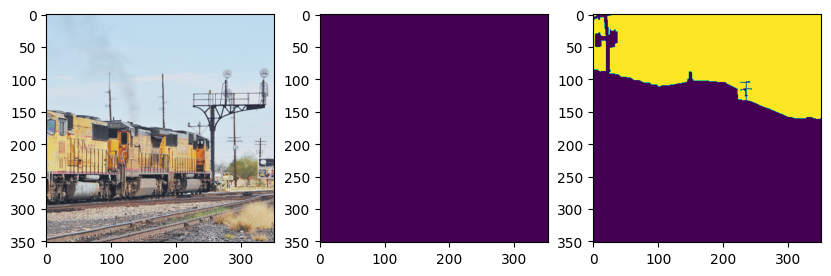

In [ ]:
i = 0

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(m(pixel_values[0]).cpu().detach().numpy().transpose(1, 2, 0))
axs[1].imshow(predicted_masks[i].cpu().detach().numpy())
axs[2].imshow(ground_truth_masks[i].cpu().detach().numpy())